# Detailed analysis for version 0.9.27 on Intel i7-12700

Copyright 2022 https://www.math-crypto.com -- GNU General Public License

**New compared to v0.9.26**
- Compile options where specified in Cargo.toml (as an overwritten production profile).
- We can reliably use lto=off, thin, or fat.
- Added opt-level=2 or 3 as option.
- Code-units option is now 1 or 16.
- No more production or release profile, since we have modified our own profile.
- Also included time for signing extrinsic as extra score. However, not analyzed in this notebook.
- Some util functions are moved to ``mathcrypto.py``

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 

from mathcrypto import * # own utils functions

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})

## Read parsed benchmark data. Clean up a bit.

In [2]:
df = pd.read_feather("processed/todo/0.9.27_i7-12700_2022-Aug-08_13h11.feather")
df['arch'] = df['arch'].fillna('none')
df['host'] = df['host'].astype('category')
df['arch'] = df['arch'].astype('category')
df['ver'] = df['ver'].astype('category')
# df['profile'] = df['profile'].astype('category') # no longer used
df['codegen-units'] = df['codegen-units'].astype('int') # 1 or 16
df['lto'] = df['lto'].astype('category') # off, thin, fat
df['nb_run'] = df['nb_run'].astype('int')
df['opt-level'] = df['opt-level'].astype('int')  # 2 or 3
df['SR25519-Verify'] = df['SR25519-Verify']*1000 # same as in benchmark palette
df.head()

,index,host,date,ver,nb_run,nb_build,cpu,BLAKE2-256,SR25519-Verify,Copy,Seq_Write,Rnd_Write,toolchain,arch,codegen-units,lto,opt-level
0,0,work-pc,2022-Aug-08_13h11,0.9.27,6,17,0.0,1410.0,1004.79,22270.0,2920.0,1280.0,stable,alderlake,1,thin,3
1,1,work-pc,2022-Aug-08_13h11,0.9.27,15,32,0.0,1340.0,991.02,22870.0,3010.0,1290.0,nightly,none,16,fat,2
2,2,work-pc,2022-Aug-08_13h11,0.9.27,12,23,0.0,1410.0,987.82,23410.0,3020.0,1290.0,stable,alderlake,16,thin,3
3,3,work-pc,2022-Aug-08_13h11,0.9.27,16,24,0.1,1340.0,992.85,22150.0,2910.0,1260.0,nightly,none,1,off,2
4,4,work-pc,2022-Aug-08_13h11,0.9.27,13,8,0.0,1340.0,986.30,24430.0,2990.0,1300.0,stable,none,16,fat,2


In [3]:
# Check for highest CPU percentage (TODO remove outliers if any)
max(df.loc[:,"cpu"])

0.4

## Boxplot of all scores

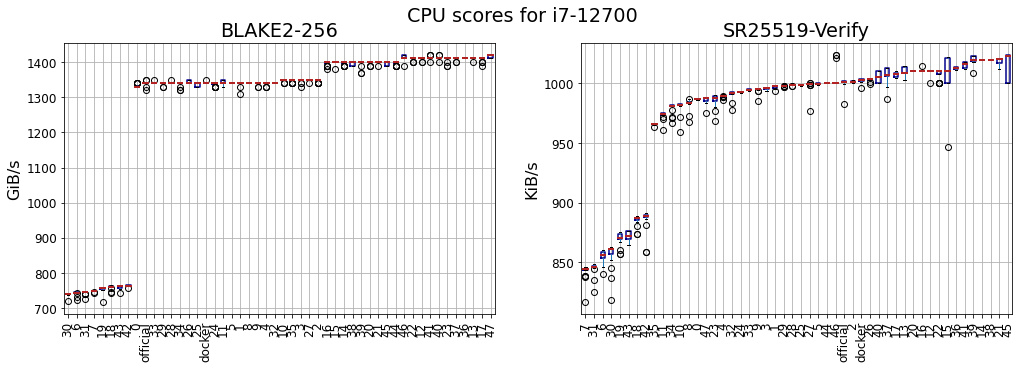

In [4]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle("CPU scores for i7-12700")
boxplot_sorted(df, by="nb_build", column="BLAKE2-256", ax=ax[0])
ax[0].set_title('BLAKE2-256')
ax[0].set_ylabel('GiB/s')
boxplot_sorted(df, by="nb_build", column="SR25519-Verify", ax=ax[1])
ax[1].set_title('SR25519-Verify')
ax[1].set_ylabel('KiB/s')
fig.savefig('images/v0.9.27/scores_cpu_i7_12700.svg', bbox_inches='tight')

We clearly see a few bad builds. Let's label them...

In [5]:
bad_builds = ["30", "6", "31", "7", "19", "18", "43", "42"]

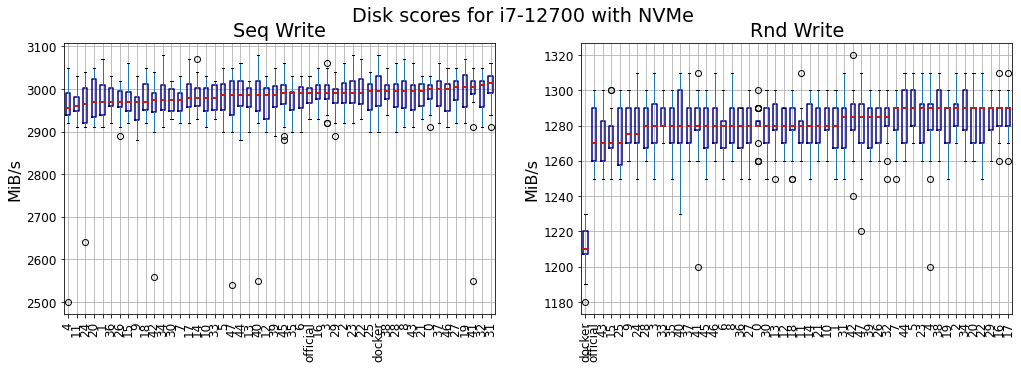

In [6]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle("Disk scores for i7-12700 with NVMe")
boxplot_sorted(df, by="nb_build", column="Seq_Write", ax=ax[0])
ax[0].set_title('Seq Write')
ax[0].set_ylabel('MiB/s')
boxplot_sorted(df, by="nb_build", column="Rnd_Write", ax=ax[1])
ax[1].set_title('Rnd Write')
ax[1].set_ylabel('MiB/s')
fig.savefig('images/v0.9.27/scores_disk_i7_12700.svg', bbox_inches='tight')

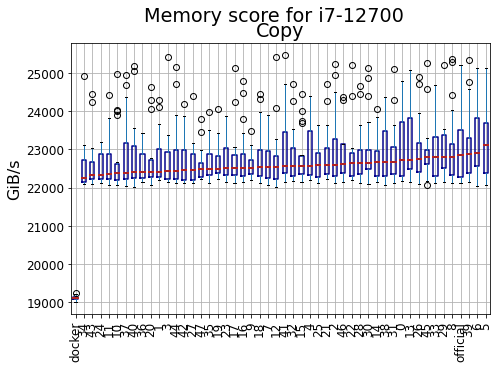

In [7]:
fig, ax = plt.subplots(1, figsize=(7.5, 5))
fig.suptitle("Memory score for i7-12700")
boxplot_sorted(df, by="nb_build", column="Copy", ax=ax)
ax.set_title('Copy')
ax.set_ylabel('GiB/s')
fig.savefig('images/v0.9.27/scores_mem_i7_12700.svg', bbox_inches='tight')

**Same conclusions** as for v0.9.26:
- Optimization has little impact on disk and memory scores (except for docker)
- Docker is still penalized here for copy and rnd write.
- Optimizing has a potential big influence on CPU scores.

**New information**:
- There are 8 builds (30, 6, 31, 7, 19, 18, 43, 42) that have very bad CPU scores.

## Table of build options

In [8]:
cat_cols = ['nb_build', 'arch', 'toolchain', 'codegen-units', 'lto', 'opt-level']
build_table = df[cat_cols].set_index('nb_build').sort_index().drop_duplicates()
print( build_table.to_markdown() )

| nb_build   | arch      | toolchain   |   codegen-units | lto        |   opt-level |
|:-----------|:----------|:------------|----------------:|:-----------|------------:|
| 0          | none      | stable      |               1 | off        |           2 |
| 1          | none      | stable      |               1 | off        |           3 |
| 10         | none      | stable      |              16 | thin       |           2 |
| 11         | none      | stable      |              16 | thin       |           3 |
| 12         | alderlake | stable      |               1 | off        |           2 |
| 13         | alderlake | stable      |               1 | off        |           3 |
| 14         | alderlake | stable      |               1 | fat        |           2 |
| 15         | alderlake | stable      |               1 | fat        |           3 |
| 16         | alderlake | stable      |               1 | thin       |           2 |
| 17         | alderlake | stable      |              

**What are the optimization options of the bad builds?**

In [9]:
build_table[build_table.index.isin(bad_builds)]

,arch,toolchain,codegen-units,lto,opt-level
nb_build,,,,,
18,alderlake,stable,16,off,2
19,alderlake,stable,16,off,3
30,none,nightly,16,off,2
31,none,nightly,16,off,3
42,alderlake,nightly,16,off,2
43,alderlake,nightly,16,off,3
6,none,stable,16,off,2
7,none,stable,16,off,3


Maybe surprisingly, it is not simply ``opt-level = 2``. It seems that ``codegen-units=16`` and ``lto=off`` is the reason, regardless of ``opt-level``.

## Find winning build options (close to Pareto efficient).

Like before, we only look at CPU scores. Since it will be usefull later, we enrich the data set with the statistical errors of the mean and the mean. For simplicity, we assume normality (although not that correct here). In that case, the error the median is 1.25 x error on the mean.

In [10]:
def calc_stats(df, score):
    stats = df[["nb_build", score]].groupby("nb_build")[score].agg(['median', 'mean', 'sem'])
    stats['± mean'] = 1.96 * stats['sem'] # 95% CI
    stats['± median'] = 1.25 * stats['± mean'] 
    sum_stats = stats[["median", "± median"]]
    sum_stats = sum_stats.rename(columns={"median": score, "± median": "Δ-" + score})
    return sum_stats

stats1 = calc_stats(df, "BLAKE2-256")
stats2 = calc_stats(df, "SR25519-Verify")
medians = pd.concat([stats1, stats2], axis=1)
medians.round(1).head()

,BLAKE2-256,Δ-BLAKE2-256,SR25519-Verify,Δ-SR25519-Verify
nb_build,,,,
0,1330.0,2.4,986.9,0.2
1,1340.0,3.8,997.5,0.6
10,1350.0,2.0,981.8,3.0
11,1340.0,3.0,974.4,1.7
12,1410.0,1.7,1010.0,1.2


These estimates of the statistical errors (given in the Δ column) are again very small. We can thus probably halve the number of samples ``NB_RUNS`` in our future benchmarking. Less waiting around!

For the rest, we now discared the bad builds.

In [11]:
medians = medians.loc[~medians.index.isin(bad_builds)]
medians.head()

,BLAKE2-256,Δ-BLAKE2-256,SR25519-Verify,Δ-SR25519-Verify
nb_build,,,,
0,1330.0,2.433828,986.915,0.216257
1,1340.0,3.812134,997.515,0.625294
10,1350.0,2.006986,981.775,2.985905
11,1340.0,3.013757,974.410,1.716181
12,1410.0,1.686206,1010.000,1.225000


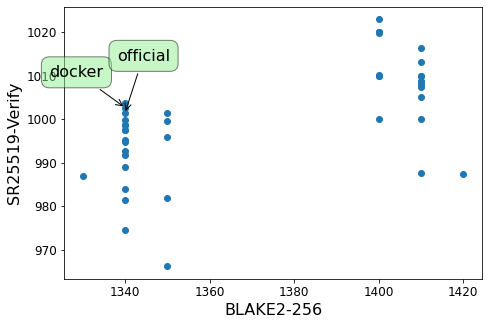

In [12]:
fig = labelled_scatter_plot(medians, "BLAKE2-256", "SR25519-Verify", ["official", "docker"])

This scatter plot looks similar to the one from v0.9.26. However, this time let us **find the (almost) Pareto efficient points in a more automatic way**. 

First, we find the **exact Pareto points** with the nice package ``paretoset``.

In [13]:
from paretoset import paretoset

In [14]:
df_xy = medians[["BLAKE2-256","SR25519-Verify"]]
mask = paretoset(df_xy, sense=["max", "max"])
df_xy_pareto = df_xy[mask]
pareto = df_xy_pareto.index.to_numpy()
df_xy_pareto

,BLAKE2-256,SR25519-Verify
nb_build,,
41,1410.0,1016.26
45,1400.0,1022.94
47,1420.0,987.42


Next, we find all builds that are **close to these Pareto efficient** ones. For that we define a box around each median with width equal to its statistical error. We then calculate the distance between all boxes.

In [15]:
# https://stackoverflow.com/questions/65107289/minimum-distance-between-two-axis-aligned-boxes-in-n-dimensions
def boxes_distance(A_min, A_max, B_min, B_max):
    delta1 = A_min - B_max
    delta2 = B_min - A_max
    u = np.max(np.array([np.zeros(len(delta1)), delta1]), axis=0)
    v = np.max(np.array([np.zeros(len(delta2)), delta2]), axis=0)
    dist = np.linalg.norm(np.concatenate([u, v]))
    return dist

In [16]:
x = "BLAKE2-256"
y = "SR25519-Verify"
dx = "Δ-BLAKE2-256"
dy = "Δ-SR25519-Verify"

pareto_ext = []
nudge = 1 # if not enough extra builds, increase this
for bA in pareto:
    A_min = np.array([medians.loc[bA][x] - nudge*medians.loc[bA][dx], medians.loc[bA][y] - nudge*medians.loc[bA][dy]])
    A_max = np.array([medians.loc[bA][x] + nudge*medians.loc[bA][dx], medians.loc[bA][y] + nudge*medians.loc[bA][dy]])

    dists_AB = {}
    for bB in medians.index:
        B_min = np.array([medians.loc[bB][x] - nudge*medians.loc[bB][dx], medians.loc[bB][y] - nudge*medians.loc[bB][dy]])
        B_max = np.array([medians.loc[bB][x] + nudge*medians.loc[bB][dx], medians.loc[bB][y] + nudge*medians.loc[bB][dy]])
        dAB = boxes_distance(A_min, A_max, B_min, B_max)
        if dAB < 1e-1:
            pareto_ext.append(bB) 
print(pareto)        
print(pareto_ext)

['41' '45' '47']
['41', '14', '15', '21', '38', '39', '45', '47']


In [17]:
# The extended set looks good. We take it as the new set.
pareto = pareto_ext
df_sel = df[df["nb_build"].isin(pareto)]

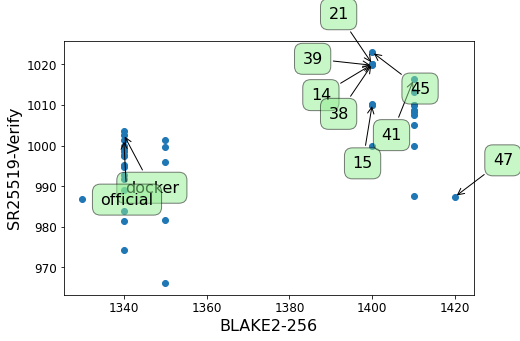

In [18]:
fig = labelled_scatter_plot(medians, "BLAKE2-256", "SR25519-Verify", ["official", "docker"] + pareto)
fig.savefig('images/v0.9.27/scatter_cpu_i7_12700.svg', bbox_inches='tight')

**We see many builds close to 45 (even 15 is there). Build 47 is of course alone, but so is build 41 (which is a bit suprising).**

In the box plot below, we see why: build 45 has quite high variance. So does build 15. However, build 41 is quite concentrated.

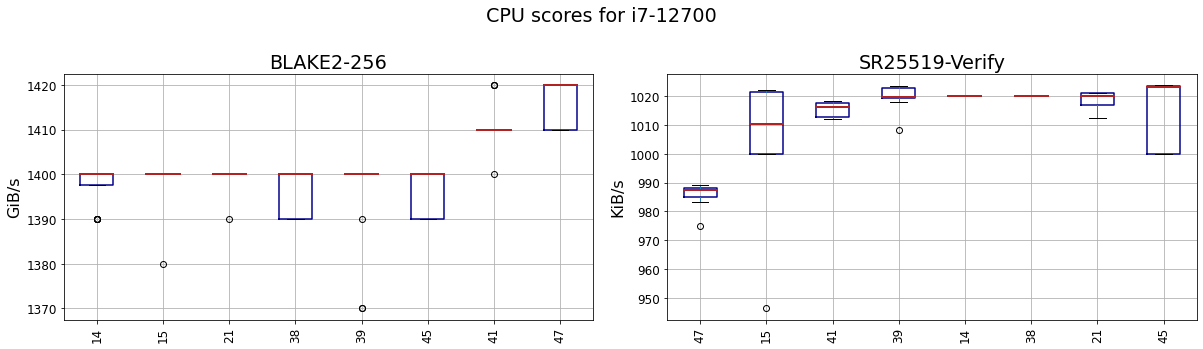

In [19]:
fig, ax = plt.subplots(1,2, figsize=(17, 5))
fig.suptitle("CPU scores for i7-12700")
boxplot_sorted(df_sel, by="nb_build", column="BLAKE2-256", ax=ax[0])
ax[0].set_title('BLAKE2-256')
ax[0].set_ylabel('GiB/s')
boxplot_sorted(df_sel, by="nb_build", column="SR25519-Verify", ax=ax[1])
ax[1].set_title('SR25519-Verify')
ax[1].set_ylabel('KiB/s')
fig.savefig('images/v0.9.27/pareto_scores_cpu_i7_12700.svg', bbox_inches='tight')

**What are the winning builds?** 

In [20]:
build_table[build_table.index.isin(pareto)]

,arch,toolchain,codegen-units,lto,opt-level
nb_build,,,,,
14,alderlake,stable,1,fat,2
15,alderlake,stable,1,fat,3
21,alderlake,stable,16,fat,3
38,alderlake,nightly,1,fat,2
39,alderlake,nightly,1,fat,3
41,alderlake,nightly,1,thin,3
45,alderlake,nightly,16,fat,3
47,alderlake,nightly,16,thin,3


- Surprisingly, ``opt-level=3`` is not always needed. However, some ``lto`` is required.
- In fact, builds 14 and 38 (``opt-level=2``) have excellent SR25519-Verify scores with zero variance.
- Build 47 is not ideal: it has best scores for BLAKE2-256 but worst for SR25519-Verify. (As shown below, it is even worse then the offical polkadot binary!)
- Build 45 is best for SR25519-Verify and third best for BLAKE2-256. Except for its high variance, build 45 would be a clear winner. It uses ``codegen-units=16``, which is a little surprising.
- Builds 38, 39 and 41 are good mixes between both scores.

For now, **we take builds 38, 39, 41 and 45 as our winning builds**. It will be interesting to see how it compares on different archs and with the extrinsic timing.

## Summary table of winning builds

Table for the overview page of our website.

In [21]:
# Summary stats with ± mean based on 95% CI
def statistics_table(df, score):
    stats = df.groupby("nb_build")[score].agg(['median', 'mean', 'sem'])
    # stats['ci95_lo'] = stats['mean'] - 1.96* stats['sem']
    # stats['ci95_hi'] = stats['mean'] + 1.96* stats['sem']
    median_official = stats['median']['official']
    stats['impr med off'] = (stats['median'] - median_official)
    stats['impr med off pct'] = stats['impr med off']/median_official*100
    return stats

In [22]:
stats_score1 = statistics_table(df, 'BLAKE2-256')
stats_score2 = statistics_table(df, 'SR25519-Verify')

In [23]:
good_builds = ['38', '39', '41', '45'] 
stats1 = stats_score1.loc[good_builds + ['official', 'docker'], ['median', 'impr med off pct']]
stats1 = stats1.rename(columns={"median": "BLAKE2-256", "impr med off pct": "relative diff (%)"})
stats2 = stats_score2.loc[good_builds + ['official', 'docker'], ['median', 'impr med off pct']]
stats2 = stats2.rename(columns={"median": "SR25519-Verify", "impr med off pct": "relative diff (%)"})
sum_stats_build = pd.concat([stats1, stats2], axis=1).round(1)
print( sum_stats_build.to_markdown() )
sum_stats_build

| nb_build   |   BLAKE2-256 |   relative diff (%) |   SR25519-Verify |   relative diff (%) |
|:-----------|-------------:|--------------------:|-----------------:|--------------------:|
| 38         |         1400 |                 4.5 |           1020   |                 1.9 |
| 39         |         1400 |                 4.5 |           1019.7 |                 1.8 |
| 41         |         1410 |                 5.2 |           1016.3 |                 1.5 |
| 45         |         1400 |                 4.5 |           1022.9 |                 2.1 |
| official   |         1340 |                 0   |           1001.4 |                 0   |
| docker     |         1340 |                 0   |           1002.6 |                 0.1 |


,BLAKE2-256,relative diff (%),SR25519-Verify,relative diff (%)
nb_build,,,,
38,1400.0,4.5,1020.0,1.9
39,1400.0,4.5,1019.7,1.8
41,1410.0,5.2,1016.3,1.5
45,1400.0,4.5,1022.9,2.1
official,1340.0,0.0,1001.4,0.0
docker,1340.0,0.0,1002.6,0.1


In [24]:
optim_builds = build_table[build_table.index.isin(good_builds)]
optim_builds

,arch,toolchain,codegen-units,lto,opt-level
nb_build,,,,,
38,alderlake,nightly,1,fat,2
39,alderlake,nightly,1,fat,3
41,alderlake,nightly,1,thin,3
45,alderlake,nightly,16,fat,3


In [25]:
pd.concat([sum_stats_build, optim_builds[["codegen-units", "lto", "opt-level"]]], axis=1)

,BLAKE2-256,relative diff (%),SR25519-Verify,relative diff (%),codegen-units,lto,opt-level
nb_build,,,,,,,
38,1400.0,4.5,1020.0,1.9,1.0,fat,2.0
39,1400.0,4.5,1019.7,1.8,1.0,fat,3.0
41,1410.0,5.2,1016.3,1.5,1.0,thin,3.0
45,1400.0,4.5,1022.9,2.1,16.0,fat,3.0
official,1340.0,0.0,1001.4,0.0,NaN,NaN,NaN
docker,1340.0,0.0,1002.6,0.1,NaN,NaN,NaN


## Comparison to v0.9.26

The optimal build on v0.9.26 was 32, which correspondsto our builds 41 (lto=thin) or 37 (lto=off) -- It is not entirely clear what is chosen by cargo. It is good to see that build 41 is also now included in our Pareto. For build 37, the results are worse.

In [27]:
build = '37' # reasons explained on website
stats1 = stats_score1.loc[[build,'official', 'docker'], ['median', 'impr med off pct']]
stats1 = stats1.rename(columns={"median": "BLAKE2-256", "impr med off pct": "relative diff (%)"})
stats2 = stats_score2.loc[[build,'official', 'docker'], ['median', 'impr med off pct']]
stats2 = stats2.rename(columns={"median": "SR25519-Verify", "impr med off pct": "relative diff (%)"})
sum_stats_build = pd.concat([stats1, stats2], axis=1).round(1)
sum_stats_build

,BLAKE2-256,relative diff (%),SR25519-Verify,relative diff (%)
nb_build,,,,
37,1410.0,5.2,1007.4,0.6
official,1340.0,0.0,1001.4,0.0
docker,1340.0,0.0,1002.6,0.1
